# Redes Neuronales en Clasificación de Sentimiento

En este notebook aprenderemos a construir redes de 3 tipos (una clásica FFN, una CNN y una RNN) para clasificar textos. Concretamente haremos análisis de sentimiento sobre tweets posteados por usuarios de una conocida aerolínea estadounidense.

<table align='left'>
<tr>
<td><img src='https://miro.medium.com/max/3260/1*8XIjunF2z6dmsVlkEuOUaw.png' width='650'/></td>
</tr>
</table>



## Datos & Mini-Exploración

Los datos que usaremos forman parte de un pequeño corpus denominado *Twitter US Airline Sentiment* disponible en Kaggle.com. Acá abajo les dejo un link para descargarlos de modo más directo. Se tienen 14.640 tweets posteados por usuarios de la aerolínea clasificados como: positivos, negativos o neutrales. Nuestra tarea será aprender a detectar el sentimiento que se expresa en el texto.



In [ ]:
!wget www.inf.utfsm.cl/~jnancu/Tweets-Airline.csv
path = ''


--2021-11-15 22:26:04--  http://www.inf.utfsm.cl/~jnancu/Tweets-Airline.csv
Resolving www.inf.utfsm.cl (www.inf.utfsm.cl)... 200.1.19.11, 2800:270:c::11
Connecting to www.inf.utfsm.cl (www.inf.utfsm.cl)|200.1.19.11|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.inf.utfsm.cl/~jnancu/Tweets-Airline.csv [following]
--2021-11-15 22:26:05--  https://www.inf.utfsm.cl/~jnancu/Tweets-Airline.csv
Connecting to www.inf.utfsm.cl (www.inf.utfsm.cl)|200.1.19.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [application/octet-stream]
Saving to: ‘Tweets-Airline.csv’

Tweets-Airline.csv  100%[===================>]   3.26M  2.54MB/s    in 1.3s    

2021-11-15 22:26:06 (2.54 MB/s) - ‘Tweets-Airline.csv’ saved [3421431/3421431]



El código de acá abajo conecta el notebook con Google Drive. Si almacenan los datos allí es una alternativa práctica.

In [ ]:
print("Mounting your Google Drive ...")

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive',force_remount=True)
 
path = "/content/drive/My Drive/Modulo-DipDL/"#Esta es la ruta


Mounting your Google Drive ...
Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
file  = 'Tweets-Airline.csv'

import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

data= pd.read_csv(path+file, sep=',')
print(data.shape)

data.head(5)

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
print(data.shape)

(11541, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


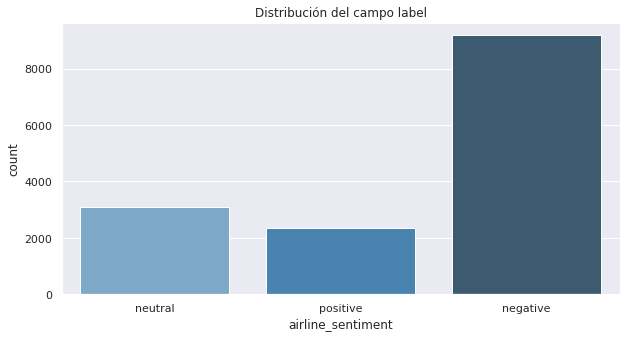

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

print("\n")
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
sns.countplot(data['airline_sentiment'],palette="Blues_d")
ax.set_title('Distribución del campo label')
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


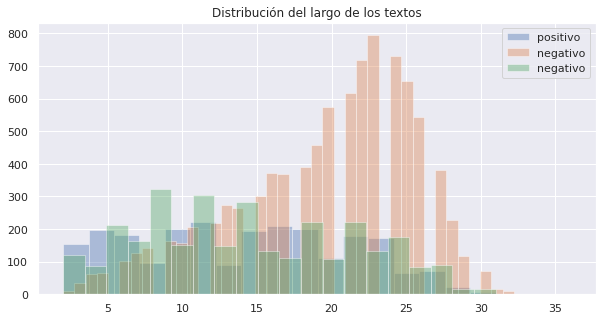

In [ ]:
lenghts_pos = []
lenghts_neg = []
lenghts_neutral = []

for sentence,label in zip(data['text'],data['airline_sentiment']):
  if label == 'negative':
    lenghts_neg.append(len(sentence.lower().split()))
  if label == 'positive':
    lenghts_pos.append(len(sentence.lower().split()))
  if label == 'neutral':
    lenghts_neutral.append(len(sentence.lower().split()))

print("\n")
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
sns.distplot(lenghts_pos,hist=True, kde=False, norm_hist=False, label='positivo',ax=ax)
sns.distplot(lenghts_neg,hist=True, kde=False, norm_hist=False, label='negativo',ax=ax)
sns.distplot(lenghts_neutral,hist=True, kde=False, norm_hist=False, label='negativo',ax=ax)
ax.set_title('Distribución del largo de los textos')
ax.legend()
plt.show()



## Splits & Selección de Clases

In [ ]:
lab_tweets = data[['text','airline_sentiment']]
lab_tweets = lab_tweets[lab_tweets['airline_sentiment'] != 'neutral']
msk = np.random.rand(len(lab_tweets)) < 0.8
data = lab_tweets
data_for_trans = lab_tweets

## De Tweets a Vectores

### Filtrado de Stopwords y Otros

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

sentences = []
labels = []

for sentence,label in zip(data['text'],data['airline_sentiment']):
  labels.append(label)
  for word in stopwords.words('english'):
    token = ''+ word+ ''
    sentence = sentence.replace(token,'')
    sentence = sentence.replace(' ', ' ')
  sentences.append(sentence)

print(len(sentences))
print(sentences[0])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
11541
@VrgnArc plu ' e crcl   expence... ck.


### Vectorización

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

TF_tokenizer = Tokenizer(num_words=5000)
TF_tokenizer.fit_on_texts(sentences)
tweet_vectors = TF_tokenizer.texts_to_matrix(sentences, mode='freq')#binary', 'count', 'tfidf'
print(tweet_vectors.shape)
#quedan menos si los neutrales son removidos


(11541, 5000)


In [ ]:
print(11541/500000)

0.023082


## Red Feed-Forward sobre Representación Vectorial TF

### Modelo

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dropout


def modelo_clasico(num_words=5000):

  model = Sequential()
  model.add(Dense(50, input_shape=(num_words,), activation="relu"))
  model.add(Dense(20,activation="relu"))
  model.add(Dense(1,activation="sigmoid"))

  opt = SGD(0.1)
  model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

  return model


In [ ]:
modelo_FF = modelo_clasico(num_words=5000)
modelo_FF.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                250050    
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 251,091
Trainable params: 251,091
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento

In [ ]:
tweet_train = tweet_vectors[msk]
tweet_test = tweet_vectors[~msk]

sentiments = data['airline_sentiment'].factorize()
sentiments_labels = sentiments[0]
sentiments_tags = sentiments[1]
print(sentiments_labels)

res_l, res_c = np.unique(sentiments_labels, return_counts=True)
print(res_l,res_c)
sentiment_train = sentiments_labels[msk]
sentiment_test = sentiments_labels[~msk] 

modelo_FF = modelo_clasico(num_words=5000)
historial_FF = modelo_FF.fit(tweet_train, sentiment_train, batch_size=64, epochs=40, verbose=2, validation_data=(tweet_test, sentiment_test))


[0 1 1 ... 0 1 1]
[0 1] [2363 9178]
Epoch 1/40
144/144 - 1s - loss: 0.5156 - accuracy: 0.7901 - val_loss: 0.4936 - val_accuracy: 0.8008 - 910ms/epoch - 6ms/step
Epoch 2/40
144/144 - 0s - loss: 0.4988 - accuracy: 0.7938 - val_loss: 0.4858 - val_accuracy: 0.8008 - 491ms/epoch - 3ms/step
Epoch 3/40
144/144 - 1s - loss: 0.4872 - accuracy: 0.7938 - val_loss: 0.4706 - val_accuracy: 0.8008 - 501ms/epoch - 3ms/step
Epoch 4/40
144/144 - 0s - loss: 0.4669 - accuracy: 0.7983 - val_loss: 0.4481 - val_accuracy: 0.8157 - 447ms/epoch - 3ms/step
Epoch 5/40
144/144 - 1s - loss: 0.4379 - accuracy: 0.8128 - val_loss: 0.4170 - val_accuracy: 0.8191 - 501ms/epoch - 3ms/step
Epoch 6/40
144/144 - 0s - loss: 0.4065 - accuracy: 0.8290 - val_loss: 0.3844 - val_accuracy: 0.8358 - 428ms/epoch - 3ms/step
Epoch 7/40
144/144 - 1s - loss: 0.3827 - accuracy: 0.8424 - val_loss: 0.3624 - val_accuracy: 0.8439 - 514ms/epoch - 4ms/step
Epoch 8/40
144/144 - 0s - loss: 0.3647 - accuracy: 0.8518 - val_loss: 0.3583 - val_accura

### Evaluación


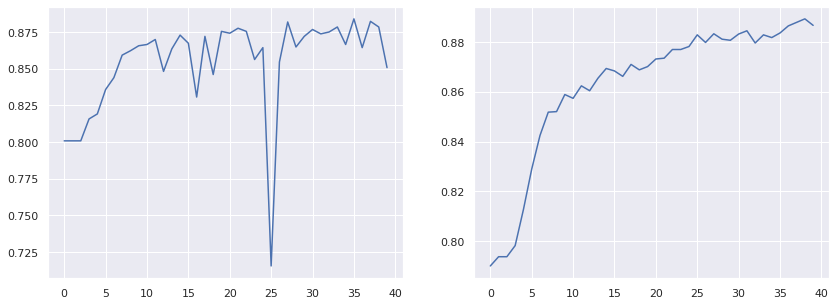


ACCURACY TEST FINAL:  0.8506825938566553

Confusion Matrix



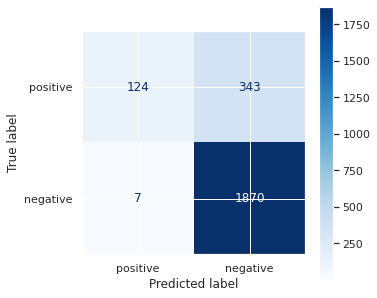


Classification Report

              precision    recall  f1-score   support

    positive       0.95      0.27      0.41       467
    negative       0.85      1.00      0.91      1877

    accuracy                           0.85      2344
   macro avg       0.90      0.63      0.66      2344
weighted avg       0.87      0.85      0.81      2344



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


fig, axis = plt.subplots(1, 2, figsize=(14,5))
axis[0].plot(historial_FF.history['val_accuracy'], label='val_acc')
axis[1].plot(historial_FF.history['accuracy'], label='acc')
plt.show()

y_pred = modelo_FF.predict(tweet_test).round().astype(int)[:,0]

acc_test = np.mean(sentiment_test == y_pred)

print("\nACCURACY TEST FINAL: " , acc_test )

target_names = [str(i) for i in range(10)]

print("\nConfusion Matrix\n")
fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(sentiment_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiments_tags)
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

print("\nClassification Report\n")

print(classification_report(sentiment_test, y_pred, target_names=sentiments_tags))


In [ ]:
test_tweet ="This is soo sad"
tweet_vector = TF_tokenizer.texts_to_matrix([test_tweet], mode='freq')
prediction = int(modelo_FF.predict(tweet_vector).round())
print("TEST TWEET: ",test_tweet)
print("PREDICTION: ",sentiments_tags[prediction])

TEST TWEET:  This is soo sad
PREDICTION:  negative


## Red Neuronal sobre Embeddings 

### Descarga de Embeddings Pre-entrenados

El comando de abajo descarga los vectores pre-entrenados a la máquina local.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2021-11-15 23:33:09--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2021-11-15 23:33:09--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-11-15 23:33:09--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('glove.twitter.27B.zip', 'r')
zip_ref.extractall('glove-global-vectors-for-word-representation/')
zip_ref.close()

BadZipFile: ignored

In [ ]:
!ls glove-global-vectors-for-word-representation/

In [ ]:
emd_dim = 64

emb_dict = {}

glove_file = 'glove.twitter.27B.' + str(emd_dim) + 'd.txt'
glove_dir = 'glove-global-vectors-for-word-representation/'

glove = open(glove_dir+glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

FileNotFoundError: ignored

### De Tweets a Secuencias de Palabras

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

emd_dim = 64
tweets = data['text'].values

Seq_tokenizer = Tokenizer(num_words=5000)
Seq_tokenizer.fit_on_texts(tweets)

vocab_size = len(Seq_tokenizer.word_index) + 1
sequences = Seq_tokenizer.texts_to_sequences(tweets)
padded_sequences = pad_sequences(sequences, maxlen=50)

print(tweets[0])
print(sequences[0])
print(padded_sequences[0])

seqs_train = padded_sequences[msk]
seqs_test = padded_sequences[~msk]

sentiments = data['airline_sentiment'].factorize()
sentiments_labels = sentiments[0]
sentiments_tags = sentiments[1]
print(sentiments_labels)

res_l, res_c = np.unique(sentiments_labels, return_counts=True)
print(res_l,res_c)
sentiment_train = sentiments_labels[msk]
sentiment_test = sentiments_labels[~msk] 


@VirginAmerica plus you've added commercials to the experience... tacky.
[103, 575, 530, 1287, 2416, 1, 2, 177]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  103  575  530 1287 2416    1    2  177]
[0 1 1 ... 0 1 1]
[0 1] [2363 9178]


### Preparacción de la Matriz Palabras Embedidas

In [ ]:
n_max_words = 5000

emb_matrix = np.zeros((n_max_words, emd_dim))

for w, i in Seq_tokenizer.word_index.items():
    if i < n_max_words:
        vect = emb_dict.get(w)
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break


### Modelos

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding, Flatten

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

def fnn_sentiment():

  fnn_model = Sequential()
  fnn_model.add(Embedding(n_max_words, emd_dim, input_length=50))
  fnn_model.add(Flatten())
  fnn_model.add(Dense(10, activation='relu'))
  fnn_model.add(Dense(1, activation='sigmoid'))
  print(fnn_model.summary())

  #fnn_model.layers[0].set_weights([emb_matrix])
  #fnn_model.layers[0].trainable = False

  fnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return fnn_model

def cnn_sentiment():

  cnn_model = Sequential()
  cnn_model.add(Embedding(n_max_words, emd_dim, input_length=50))
  cnn_model.add(Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'))
  cnn_model.add(MaxPooling1D(pool_size=2))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(10, activation='relu'))
  cnn_model.add(Dense(1, activation='sigmoid'))
  print(cnn_model.summary())
  
  cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return cnn_model


### Entrenamiento

In [ ]:
fnn_model = fnn_sentiment()

fnn_history = fnn_model.fit(seqs_train, sentiment_train, epochs=10, batch_size=64, validation_data=(seqs_test, sentiment_test))


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 50, 64)            320000    
                                                                 
 flatten_10 (Flatten)        (None, 3200)              0         
                                                                 
 dense_24 (Dense)            (None, 10)                32010     
                                                                 
 dense_25 (Dense)            (None, 1)                 11        
                                                                 
Total params: 352,021
Trainable params: 352,021
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
144/144 [==============================] - 1s 4ms/step - loss: 0.4349 - accuracy: 0.7900 - val_loss: 0.3221 - val_accuracy: 0.8008
Epoch 2/10
144/144 [============

In [ ]:
cnn_model = cnn_sentiment()
cnn_history = cnn_model.fit(seqs_train, sentiment_train, epochs=10, batch_size=64, validation_data=(seqs_test, sentiment_test))


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 64)            320000    
                                                                 
 conv1d_4 (Conv1D)           (None, 50, 64)            32832     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 1600)              0         
                                                                 
 dense_22 (Dense)            (None, 10)                16010     
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                     

### Evaluación

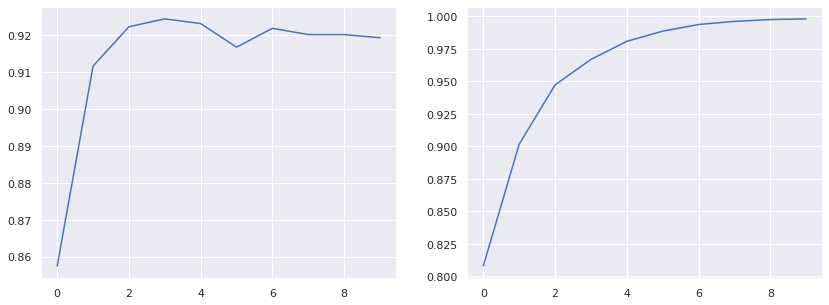


ACCURACY TEST FINAL:  0.9193686006825939

Confusion Matrix



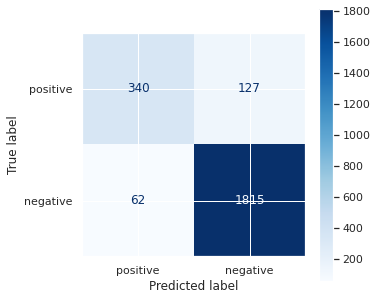


Classification Report

              precision    recall  f1-score   support

    positive       0.85      0.73      0.78       467
    negative       0.93      0.97      0.95      1877

    accuracy                           0.92      2344
   macro avg       0.89      0.85      0.87      2344
weighted avg       0.92      0.92      0.92      2344



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


fig, axis = plt.subplots(1, 2, figsize=(14,5))
axis[0].plot(fnn_history.history['val_accuracy'], label='val_acc')
axis[1].plot(fnn_history.history['accuracy'], label='acc')
plt.show()

y_pred =  fnn_model.predict(seqs_test).round().astype(int)[:,0]

acc_test = np.mean(sentiment_test == y_pred)

print("\nACCURACY TEST FINAL: " , acc_test )

target_names = [str(i) for i in range(10)]

print("\nConfusion Matrix\n")
fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(sentiment_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiments_tags)
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

print("\nClassification Report\n")

print(classification_report(sentiment_test, y_pred, target_names=sentiments_tags))


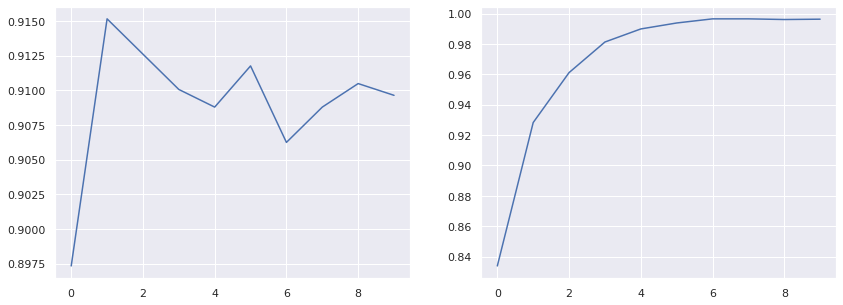


ACCURACY TEST FINAL:  0.9096308867204073

Confusion Matrix



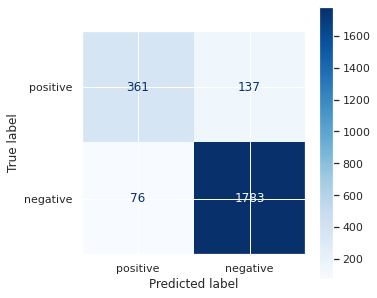


Classification Report

              precision    recall  f1-score   support

    positive       0.83      0.72      0.77       498
    negative       0.93      0.96      0.94      1859

    accuracy                           0.91      2357
   macro avg       0.88      0.84      0.86      2357
weighted avg       0.91      0.91      0.91      2357



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


fig, axis = plt.subplots(1, 2, figsize=(14,5))
axis[0].plot(cnn_history.history['val_accuracy'], label='val_acc')
axis[1].plot(cnn_history.history['accuracy'], label='acc')
plt.show()

y_pred =  cnn_model.predict(seqs_test).round().astype(int)[:,0]

acc_test = np.mean(sentiment_test == y_pred)

print("\nACCURACY TEST FINAL: " , acc_test )

target_names = [str(i) for i in range(10)]

print("\nConfusion Matrix\n")
fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(sentiment_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiments_tags)
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

print("\nClassification Report\n")

print(classification_report(sentiment_test, y_pred, target_names=sentiments_tags))


In [ ]:
test_word ="This is soo sad"
seq = Seq_tokenizer.texts_to_sequences([test_word])
seq = pad_sequences(seq,maxlen=200)
prediction = int(cnn_model.predict(seq).round().item())
print("TEST TWEET: ",test_tweet)
print("PREDICTION: ",sentiments_tags[prediction])


TEST TWEET:  This is soo sad
PREDICTION:  negative


### Modelo Recurrente

In [ ]:
glove_model = Sequential()
glove_model.add(Embedding(n_max_words, emd_dim, input_length=50))
glove_model.add(LSTM(50, dropout=0.5))
glove_model.add(Dropout(0.2))
glove_model.add(Dense(1, activation='sigmoid'))
glove_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(glove_model.summary())

#glove_model.layers[0].set_weights([emb_matrix])
#glove_model.layers[0].trainable = False

glove_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 50, 64)            320000    
                                                                 
 lstm_4 (LSTM)               (None, 50)                23000     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_30 (Dense)            (None, 1)                 51        
                                                                 
Total params: 343,051
Trainable params: 343,051
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
glove_history = glove_model.fit(seqs_train, sentiment_train, epochs=10, batch_size=64, validation_data=(seqs_test, sentiment_test))


Epoch 1/10
144/144 [==============================] - 1s 7ms/step - loss: 0.0304 - accuracy: 0.9896 - val_loss: 0.3618 - val_accuracy: 0.9113
Epoch 2/10
144/144 [==============================] - 1s 7ms/step - loss: 0.0237 - accuracy: 0.9918 - val_loss: 0.3654 - val_accuracy: 0.9049
Epoch 3/10
144/144 [==============================] - 1s 7ms/step - loss: 0.0254 - accuracy: 0.9904 - val_loss: 0.4207 - val_accuracy: 0.9023
Epoch 4/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0234 - accuracy: 0.9917 - val_loss: 0.4208 - val_accuracy: 0.9070
Epoch 5/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0240 - accuracy: 0.9923 - val_loss: 0.4644 - val_accuracy: 0.9053
Epoch 6/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0183 - accuracy: 0.9935 - val_loss: 0.5074 - val_accuracy: 0.9053
Epoch 7/10
144/144 [==============================] - 1s 7ms/step - loss: 0.0253 - accuracy: 0.9911 - val_loss: 0.4543 - val_accuracy: 0.9074
Epoch 